# Behavioral Testing



To test non unit-testable functionality of our code, we performed behavioral testing by isolating different components of our RTOS, graphing their behavior, and comparing that to our expectations. See results below.

In [87]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, import the plotting function.

In [8]:
import sys
sys.path.append('../plot')
data_dir = "behavioral_test_data"

from plot import plot_rtos_log

### Test 1: Only long tasks with no interrupts from TIM2 or TIM3:

Initialization: One long task in queue, no interrupts enabled

Expected: The graph should show a continuous block of execution for long tasks, managed by the round-robin scheduler without any preemption. The long task should end and restart at a consistent interval, which corresponds to how long it takes the MCU to print out the numbers 1 to 1000.

Result: The long task does indeed run consistently and restart itself after a consistent interval of time. It appears to take about 11 ticks for it to run.


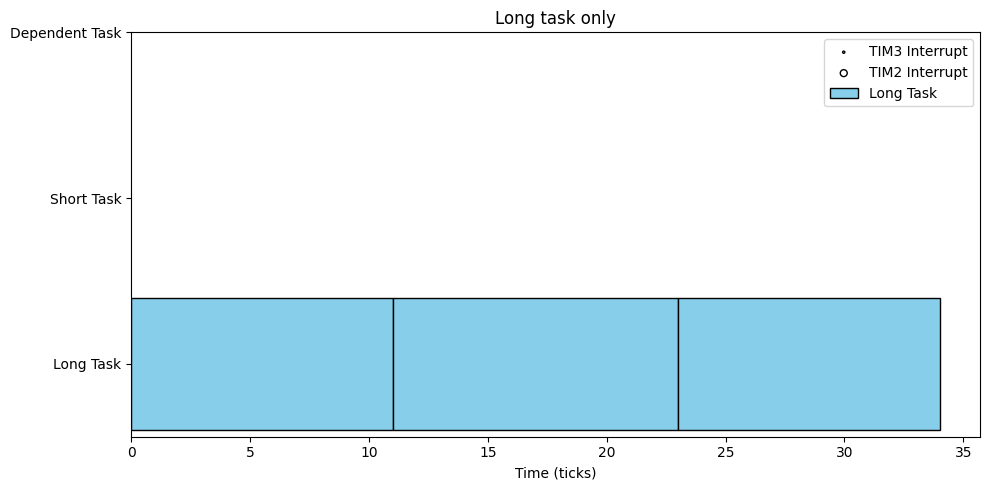

In [ ]:

plot_rtos_log(f"{data_dir}/long_task_only.txt", title="Long task only")


### Test 2: Long tasks with interrupts from TIM3:

Initialization: One long task in queue, TIM3 interrupt enabled to run every three ticks

Expected: The long task should run to completion and requeue itself to the end of the queue. The TIM3 interrupt should go off every 3 ticks and add a short task to the queue each time. Those short tasks should start to run after the first long task finishes, and a number of short tasks should run equal to the number of TIM3 interrupts that went off during the long task's execution. Since the dependent task is directly tied to run after the short task, the dependent task should also run right after the short task any time the short task runs.

Result: A long task runs, and during that time three TIM3 interrupts go off. As expected, the long task runs to completion and then the three short tasks that have been queued run. The dependent tasks run right after each short task.


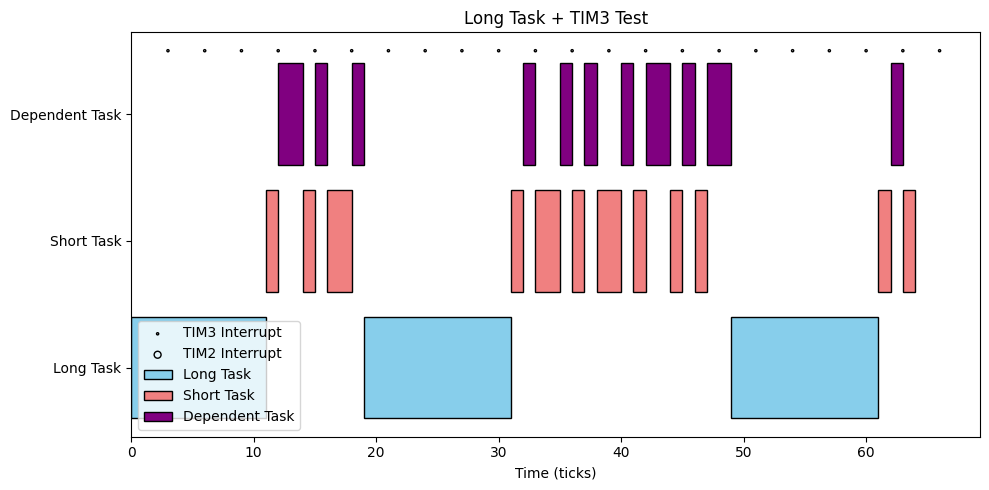

In [11]:

plot_rtos_log(f"{data_dir}/long_task_tim3.txt", title="Long Task + TIM3 Test")


### Test 3: Long tasks with interrupts from TIM2:

Initialization: One long task in the queue, TIM2 interrupts enabled and set to limit tasks to running for 10 ticks

Expected: Since the long task ran for 11 ticks in test 1, we expected it to run for ten ticks before being interrupted by TIM2, but since there are no other tasks in the queue it should continue running and finish at the 11 tick mark. It should then restart (because the long task requeues itself).

Result: The long task does get interrupted at 10 ticks and then resumes, stopping at 11 ticks and then restarting.

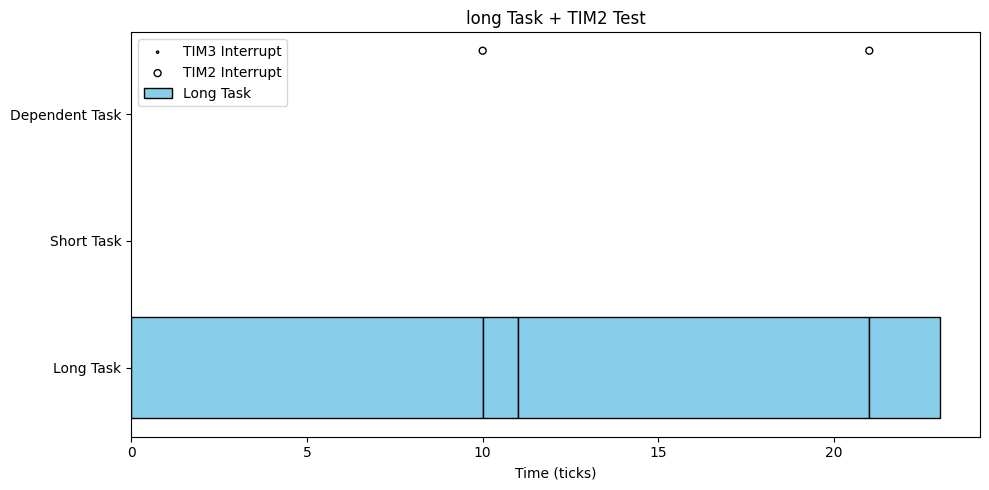

In [91]:

plot_rtos_log(f"{data_dir}/long_tim2.txt", title="long Task + TIM2 Test")


### Test 4: Short task only:

Initialization: One short task in the queue, no interrupts

Expected: The short task should run once, and then the dependent task should run because it is linked to the short task. Exactly how long that should take is unknown, but it's the length of time the MCU takes to print the numbers 1 to 100. Since the short task does not requeue itself, no other tasks should run after this.

Result: We see the short task run for one tick and then the dependent task runs for one tick. This is as expected.

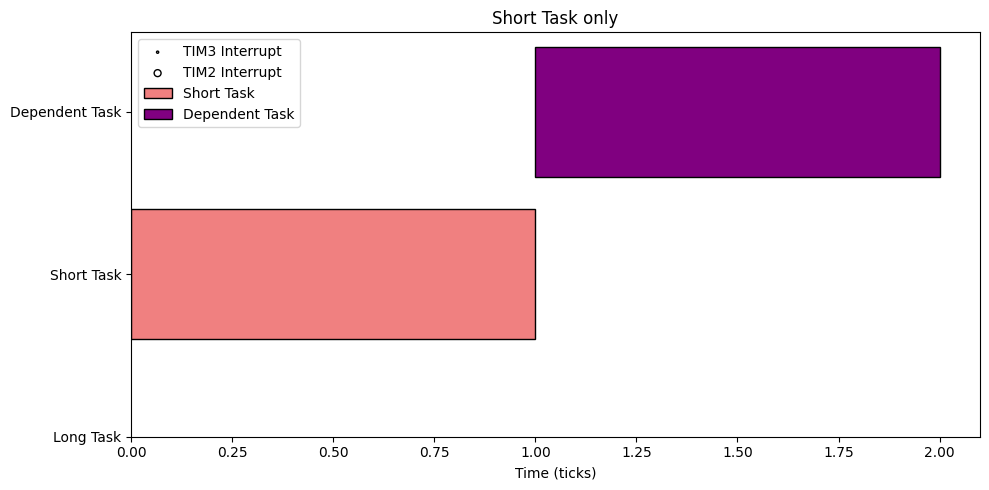

In [92]:

plot_rtos_log(f"{data_dir}/short_task_only.txt", title="Short Task only")


### Test 5: Short task with TIM3 interrupts:

Initialization: Short task in queue at first, TIM3 enabled with interupt every 3 ticks to add a short task to the queue.

Expected: The short task and then dependent task should run, then the scheduler should wait until a new task is added to the queue. This should happen when TIM3 goes off, and then right after that the newly queued short task should run, then the dependent task.

Result: As expected, the short task then dependent task runs, then the scheduler waits, then the TIM3 interrupt goes off and the new short task starts.


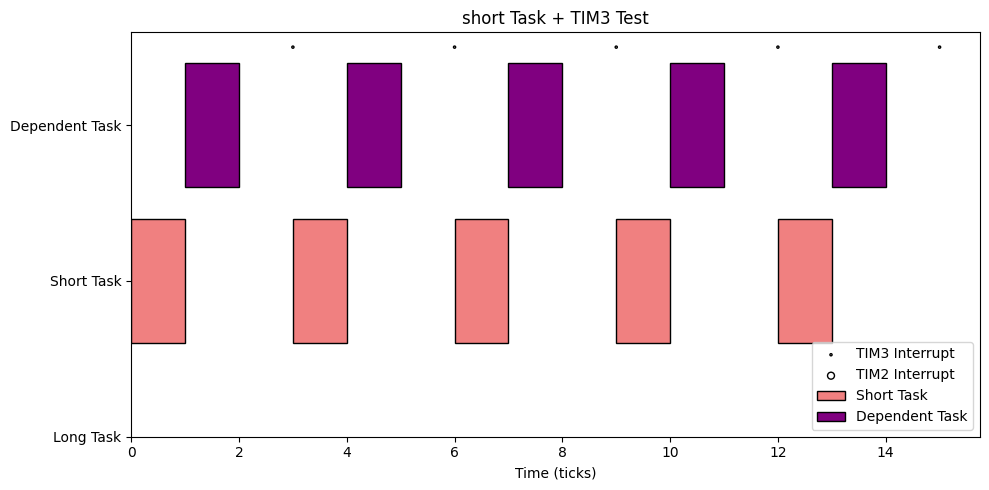

In [93]:

plot_rtos_log(f"{data_dir}/short_tim3.txt", title="short Task + TIM3 Test")


### Test 6: Short task with TIM2 interrupts:

Initialization: Short task in queue, TIM2 enable to stop tasks after 10 ticks.

Expected: Since we saw from test 4 that the short and dependent tasks each take one tick to run, we expected them to never get interrupted by TIM2. Also, since short tasks don't requeue themselves, the short task should run just once, then the dependent task, then the scheduler should do nothing because there are no tasks left in the queue.

Result: The short task runs, then the dependent. As expected, they each just run once and are never interrupted.


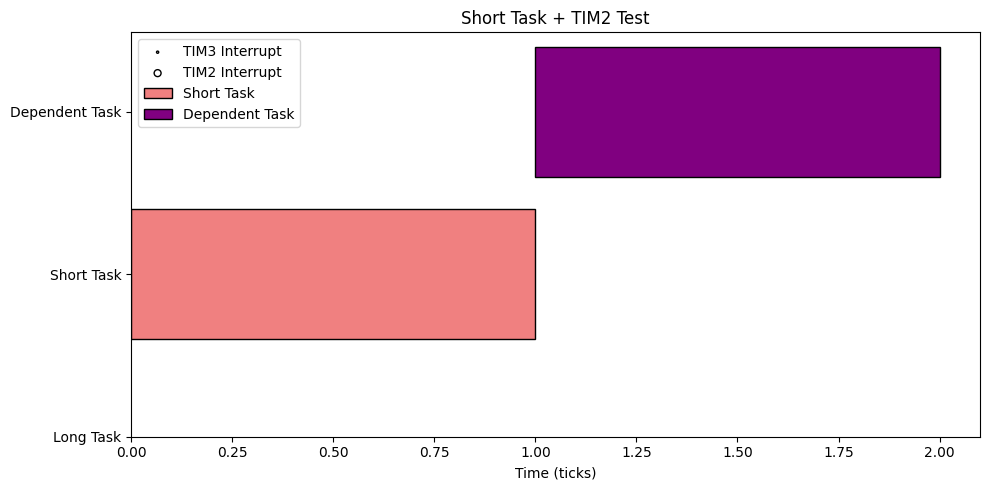

In [94]:

plot_rtos_log(f"{data_dir}/short_tim2.txt", title="Short Task + TIM2 Test")


### Test 7: Normal situation, Long task + TIM2 + TIM3:

Initialization: Long task starts in queue, TIM2 enabled to stop tasks after 10 ticks, TIM3 enabled to enqueue short task every 3 ticks.

Expected: This situation is more complicated so there are many expectations:
- The long task should start and short tasks should build up in the queue as the TIM3 goes off multiple times.
- The TIM2 timer should preempt the long tasks before it finishes (at 10 ticks). 
- When the long task resumes, it should only run for a short period because it only has a tick or so of work left to do (since as seen in test 1 its work takes about 11 ticks).
- TIM2 interrupts only ever interrupt the long task since none of the short and dependent tasks are long enough to use up all the allocated time slice.
- When TIM2 interrupts happen, the short tasks in the queue gets run.

Result: These all happen as expected.


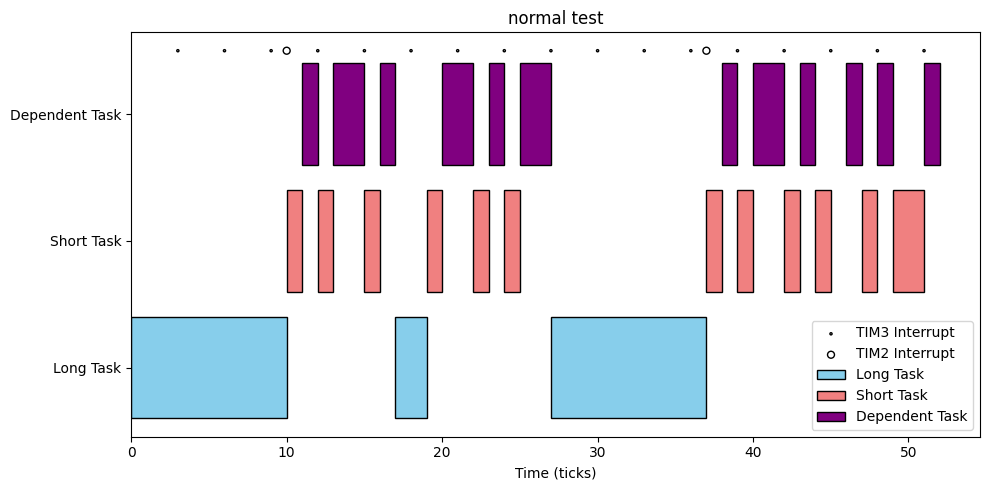

In [95]:
plot_rtos_log(f"{data_dir}/three_task_data.txt", title="normal test")


### Test 8: Initialize with no task with TIM2 + TIM3:

Intialization: No task, TIM2 enabled to stop task after 10 ticks, TIM3 enqueues short task every 3 ticks.

Expected: No tasks should run at first, but once TIM3 goes off it should add a short task to the queue and trigger that running. TIM2 should do nothing here since both the short and dependent tasks are too short to be preempted.

Result: If you look closely at the x axis you can see it starts at three, indicating that the scheduler was not running any tasks from ticks 0-3, as expected. Once TIM3 goes off, a short task starts running, then a dependent task runs, then the scheduler pasues until a new task is queued.


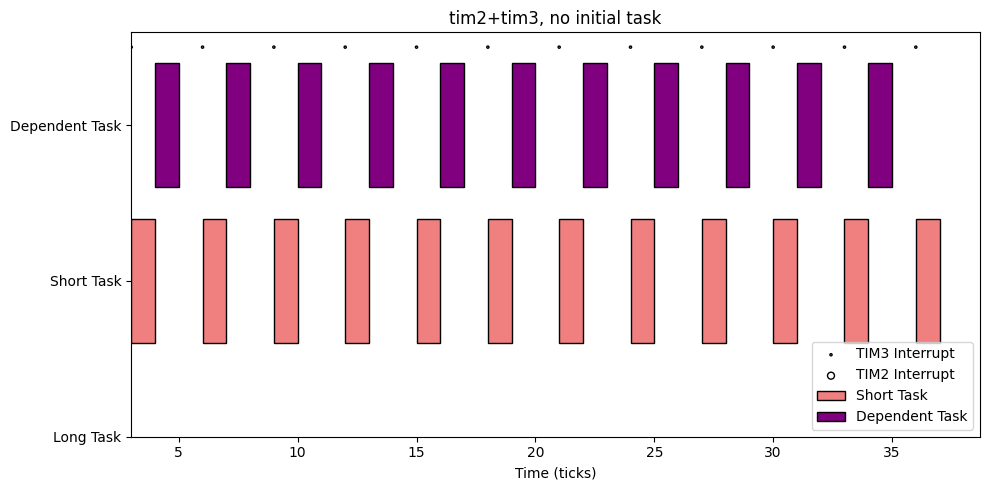

In [96]:

plot_rtos_log(f"{data_dir}/tim2tim3_no_task.txt", title="tim2+tim3, no initial task")


### Test 9: Initialize with no task, with TIM3

Initialization: No tasks in queue, TIM3 set to enqueue a task every 3 ticks

Expected: Shoudl be the same as the last graph (test 8), since TIM2 didn't do anything in the last setup anyway

Result: The graphs indeed look the same (the tasks only look smaller in this one because the graph is showing a longer period of time)

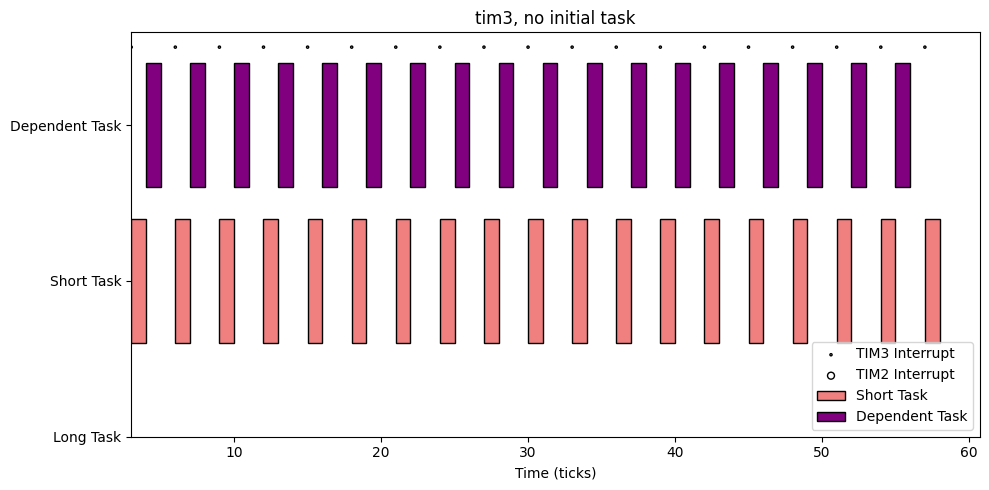

In [97]:


plot_rtos_log(f"{data_dir}/tim3_no_task.txt", title="tim3, no initial task")
